# **SELF-DRIVING CAR **

**The Training Process**

We will now import all the libraries needed for training process. It will use Tensorflow backend and keras at frontend.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow
tensorflow.config.run_functions_eagerly(True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense,LSTM,ConvLSTM2D,TimeDistributed
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import warnings
warnings.filterwarnings("ignore")

We wil use datadir as the name given to the folder itself and take the parameters itself. Using head, we will show the first five values for the CSV on the desired format.

In [2]:
datadir = ''
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, '../input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make/driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\center_2022_04_10_12_24_41_840.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\center_2022_04_10_12_24_41_908.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\center_2022_04_10_12_24_41_976.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\center_2022_04_10_12_24_42_044.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\center_2022_04_10_12_24_42_116.jpg   

                                                                                  left  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\left_2022_04_10_12_24_41_840.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\left_2022_04_10_12_24_41_908.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\left_2022_04_10_12_24_41_976.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\left_2022_04_10_12_24_42_044.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\left_2022_04_10_12_24_42_116.jpg   

                                                                                  right  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\right_2022_04_10_12_24_41_840.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\right_2022_04_10_12_24_41_908.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\right_2022_04_10_12_24_41_976.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\right_2022_04_10_12_24_42_044.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset\IMG\right_2022_04_10_12_24_42_116.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000013  
1  0.0       0.0       0        0.000010  
2  0.0       0.0       0        0.000008  
3  0.0       0.0       0        0.000021  
4  0.0       0.0       0        0.000014

As this is picking up the entire path from the local machine, we need to use ntpath function to get the network path assigned. We will declare a name path_leaf and assign accordingly.

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
#data.head()
data.info

<bound method DataFrame.info of                                   center                              left  \
0     center_2022_04_10_12_24_41_840.jpg  left_2022_04_10_12_24_41_840.jpg   
1     center_2022_04_10_12_24_41_908.jpg  left_2022_04_10_12_24_41_908.jpg   
2     center_2022_04_10_12_24_41_976.jpg  left_2022_04_10_12_24_41_976.jpg   
3     center_2022_04_10_12_24_42_044.jpg  left_2022_04_10_12_24_42_044.jpg   
4     center_2022_04_10_12_24_42_116.jpg  left_2022_04_10_12_24_42_116.jpg   
...                                  ...                               ...   
3925  center_2022_04_10_12_29_14_980.jpg  left_2022_04_10_12_29_14_980.jpg   
3926  center_2022_04_10_12_29_15_047.jpg  left_2022_04_10_12_29_15_047.jpg   
3927  center_2022_04_10_12_29_15_116.jpg  left_2022_04_10_12_29_15_116.jpg   
3928  center_2022_04_10_12_29_15_187.jpg  left_2022_04_10_12_29_15_187.jpg   
3929  center_2022_04_10_12_29_15_279.jpg  left_2022_04_10_12_29_15_279.jpg   

                               

We will bin the number of values where the number will be equal to 25 (odd number aimed to get center distribution). We will see the histogram using the np.histogram option on data frame ‘steering’, we will divide it to the number of bins.
We keep samples at 400 and then we draw a line. We see the data is centered along the middle that is 0.

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)

In [5]:
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


print(bins)

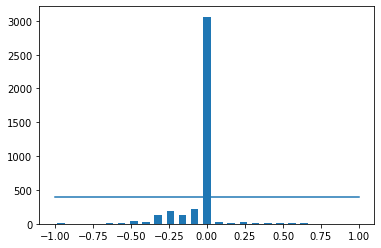

In [6]:
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), \
(samples_per_bin, samples_per_bin))

In [7]:
print('total data:', len(data))

total data: 3930


We wil specify a variable remove_list.We will specify samples we want to remove using looping construct through every single bin we will iterate through all the steering data. We will shuffle the data and romve some from it as it is now uniformly structured after shuffling.The output will be the distribution of steering angle that are much more uniform. There are significant amount of left steering angle and right steering angle eliminating the bias to drive straight all the time.

In [8]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))

removed: 2661


In [9]:
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

remaining: 1269


**Plot on it**

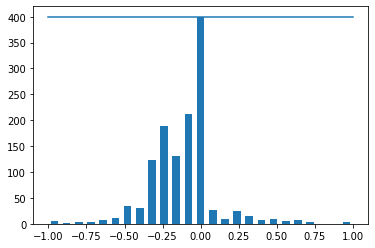

In [10]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), \
(samples_per_bin, samples_per_bin))

In [11]:
print(data.iloc[1])

center      center_2022_04_10_12_24_42_256.jpg
left        left_2022_04_10_12_24_42_256.jpg  
right       right_2022_04_10_12_24_42_256.jpg 
steering   -0.05                              
throttle    0.01613                           
reverse     0                                 
speed       0.034646                          
Name: 6, dtype: object


We will now load the image into array to manipulate them accordingly. We will define a function named locd_img_steering. We will have image path as empty list and steering as empty list and then loop through. We use iloc selector as data frame based on the specific index we will use cut data for now.

In [12]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '../input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make/IMG', data)

We will be splitting the image path as well as storing arrays accordingly.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3045
Valid Samples: 762


We will have the histograms now.

Text(0.5, 1.0, 'Validation set')

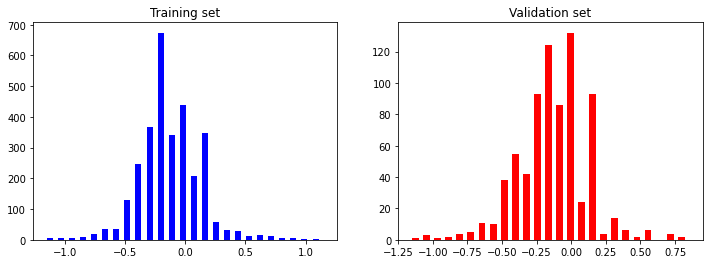

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

**Augmentation and image pre-processing**

The biggest challenge was generalizing the behavior of the car on Track_2 which it was never trained for. In a real-life situation, we can never train a self-driving car model for every track possible, as the data will be too huge to process. Also, it is not possible to gather the dataset for all the weather conditions and roads. Thus, there is a need to come up with an idea of generalizing the behavior on different tracks. This problem is solved using image preprocessing and augmentation techniques.

*Zoom*

The images in the dataset have relevant features in the lower part where the road is visible. The external environment above a certain image portion will never be used to determine the output and thus can be cropped. Approximately, 30% of the top portion of the image is cut and passed in the training set. The snippet of code and transformation of an image after cropping and resizing it to original image can be seen in below.

Text(0.5, 1.0, 'Zoomed Image')

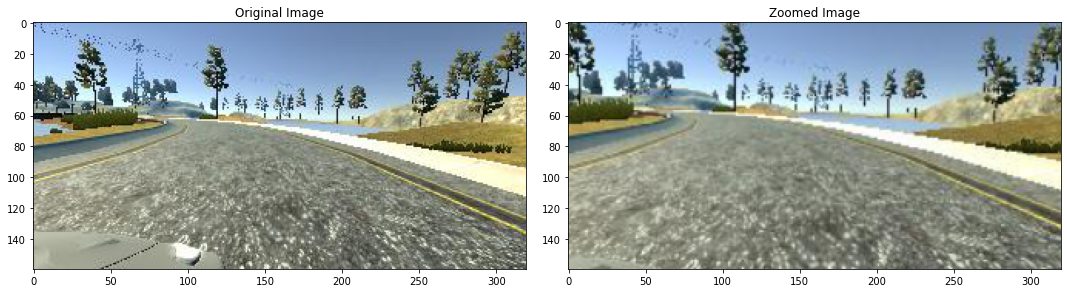

In [15]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

*Shift (horizontal/vertical)*

The image is shifted by a small amount, it is vertical shift and horizontal shift as below.


Text(0.5, 1.0, 'Panned Image')

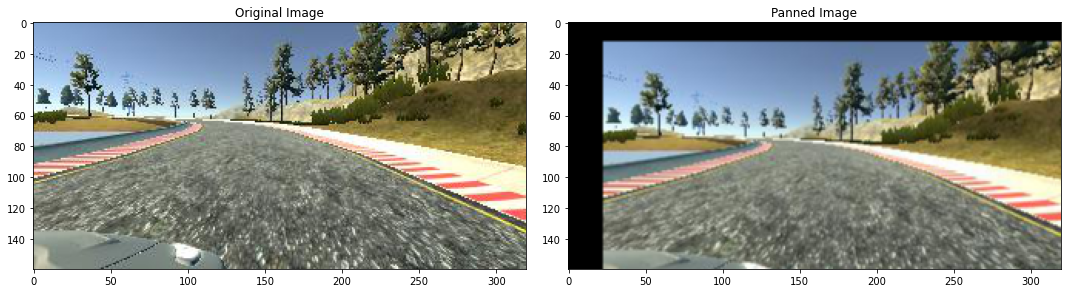

In [16]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

*Brightness*

To generalize to the weather conditions with bright sunny day or cloudy, lowlight conditions, the brightness augmentation can prove to be very useful. The code snippet and increase of brightness can be seen below. Similarly, I have randomly also lowered down the level of brightness for other conditions. 


Text(0.5, 1.0, 'Brightness altered image ')

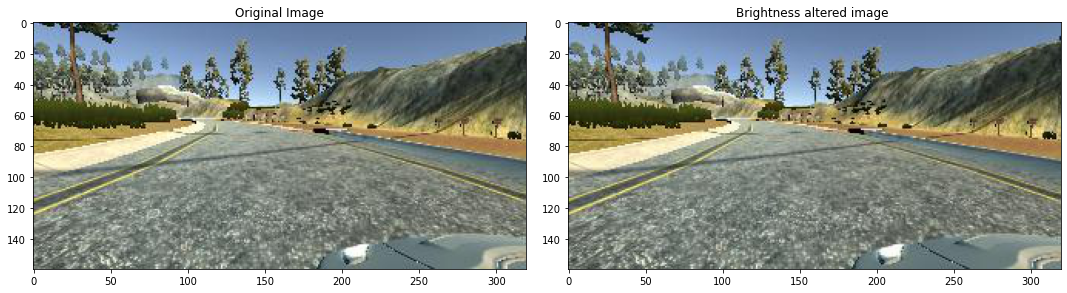

In [17]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

*Flip (horizontal)*

The image is flipped horizontally (i.e. a mirror image of the original image is passed to the dataset). The motive behind this is that the model gets trained for similar kinds of turns on opposite sides too. This is important because Track 1 includes only left turns. The snippet of code and transformation of an image after flipping it can be seen in below.

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

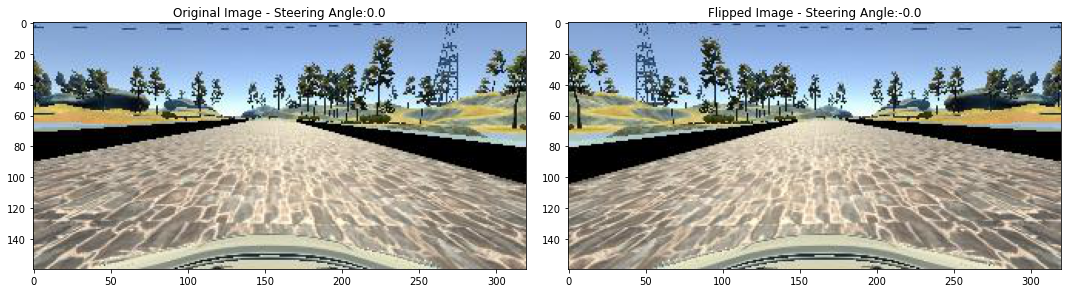

In [18]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

To have a look what we have at this moment

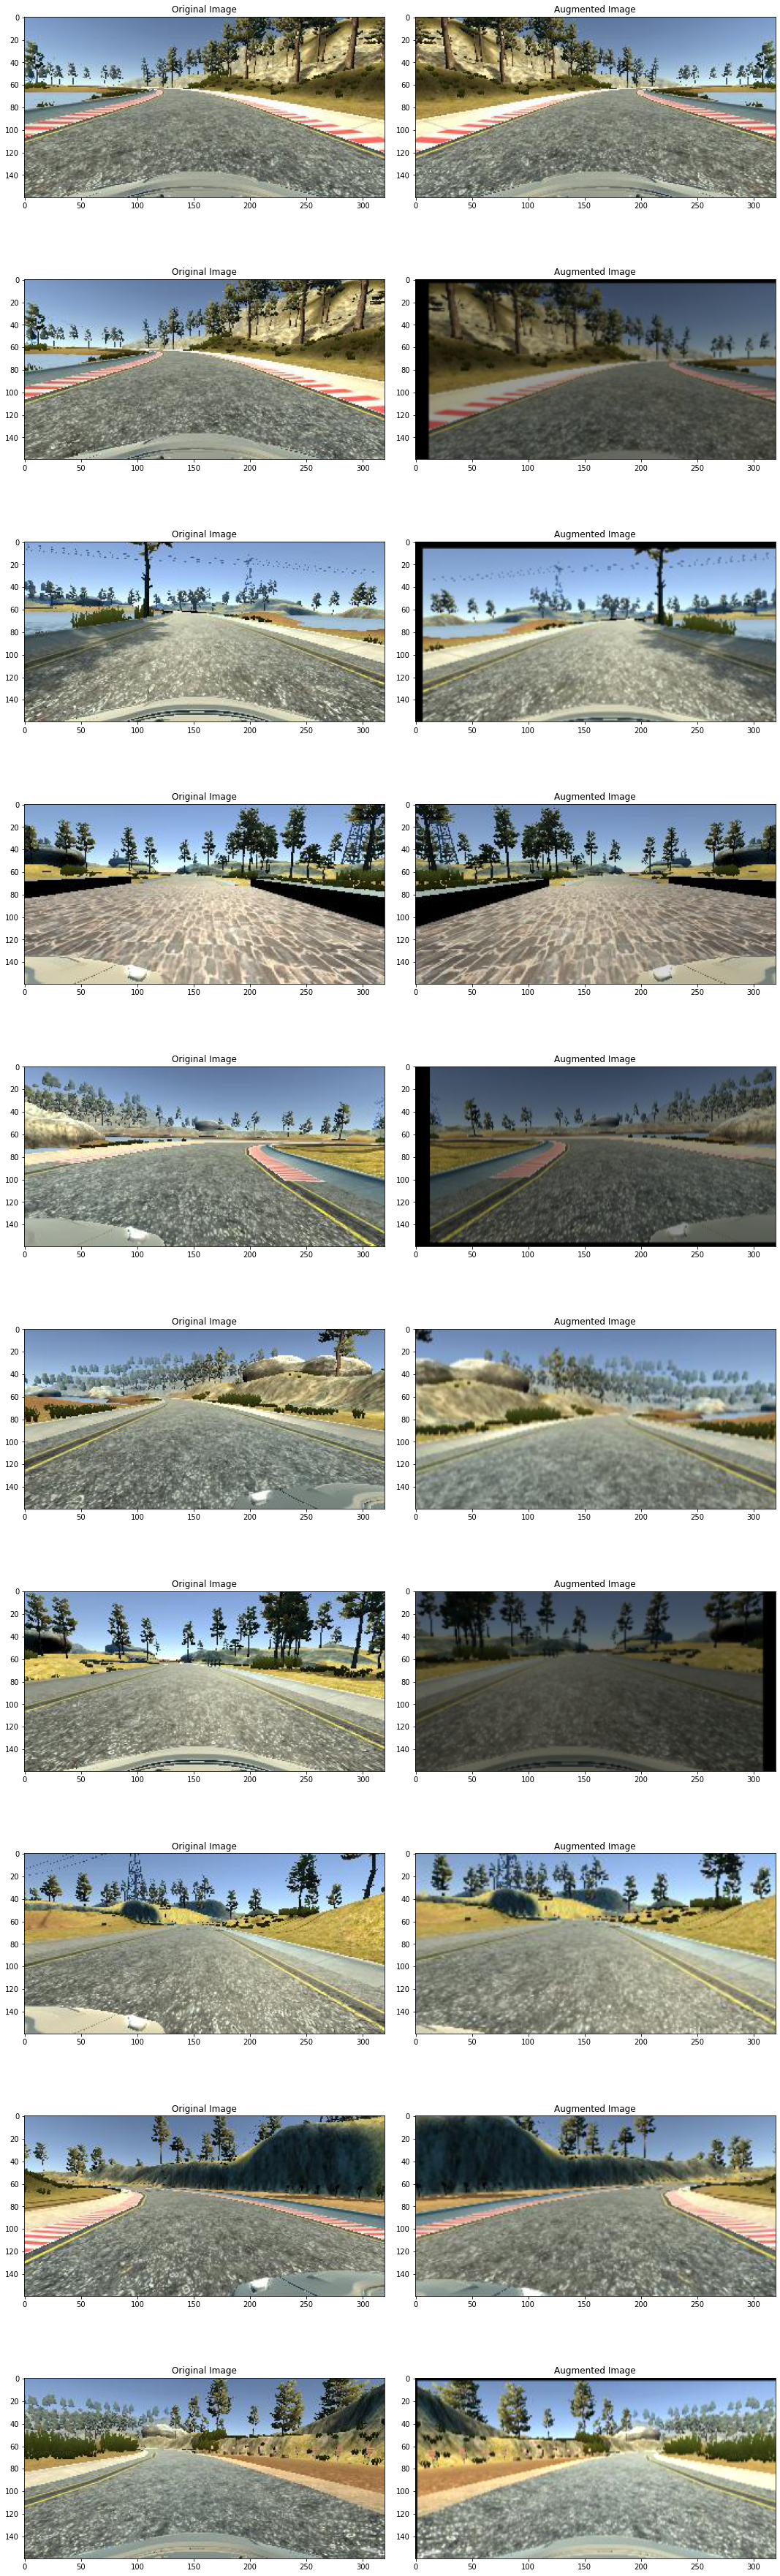

In [19]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [20]:
def convert_to_5D(image):
    # add an extra dimension to the image
    image = np.expand_dims(image, axis=0)
    
    # create 5D data format
    data = np.zeros((1, image.shape[1], image.shape[2], image.shape[3]))
    data[0, :, :, :] = image
    
    return data

I continued by doing some image processing. I cropped the image to remove the unnecessary features, changes the images to YUV format, used gaussian blur, decreased the size for easier processing and normalized the values

In [21]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    #img=convert_to_5D(img)
    return img
#image = image_paths[100]
#original_image = mpimg.imread(image)
#preprocessed_image = img_preprocess(original_image)
 
#fig, axs = plt.subplots(1, 2, figsize=(15, 10))
#fig.tight_layout()
#axs[0].imshow(original_image)
#axs[0].set_title('Original Image')
#xs[1].imshow(preprocessed_image)
#axs[1].set_title('Preprocessed Image')

To compare and visualize I plotted the original and the pre-processed image.

In [22]:
#image = image_paths[100]
#original_image = mpimg.imread(image)
#preprocessed_image = img_preprocess(original_image)
 
#fig, axs = plt.subplots(1, 2, figsize=(15, 10))
#fig.tight_layout()
#axs[0].imshow(original_image)
#axs[0].set_title('Original Image')
#axs[1].imshow(preprocessed_image)
#axs[1].set_title('Preprocessed Image')

In [23]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

So far so good. Next, I converted all the images into numpy array.

In [24]:
#x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
#x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
#fig, axs = plt.subplots(1, 2, figsize=(15, 10))
#fig.tight_layout()
 
#axs[0].imshow(x_train_gen[0])
#axs[0].set_title('Training Image')
 
#axs[1].imshow(x_valid_gen[0])
#axs[1].set_title('Validation Image')

In [25]:
def LarvaModel():
    model = Sequential()
    model.add(ConvLSTM2D(24, (5, 5), strides=(2, 2), input_shape=(None,66,200,3), activation="elu", return_sequences=True))
    model.add(ConvLSTM2D(36, (5, 5), strides=(2, 2), activation="elu", return_sequences=True))
    #model.add(ConvLSTM2D(48, (5, 5), strides=(2, 2), activation="elu", return_sequences=True))
    model.add(ConvLSTM2D(64, (3, 3), activation="elu", return_sequences=True,))
    model.add(ConvLSTM2D(64, (3, 3), activation="elu", return_sequences=True))
    model.add(TimeDistributed(Flatten()))

    model.add(Dense(100, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3), loss="mse")

    return model


In [26]:
def nvidiaModel1():
    model = Sequential()
    model.add(ConvLSTM2D(24, (5, 5), strides=(2, 2), input_shape=(None,66,200,3), activation="elu", return_sequences=True))
    model.add(ConvLSTM2D(36, (5, 5), strides=(2, 2), activation="elu", return_sequences=True))
    #model.add(ConvLSTM2D(48, (5, 5), strides=(2, 2), activation="elu", return_sequences=True))
    model.add(ConvLSTM2D(64, (3, 3), activation="elu", return_sequences=True,))
    #model.add(ConvLSTM2D(64, (3, 3), activation="elu", return_sequences=True))
    model.add(TimeDistributed(Flatten()))

    model.add(Dense(100, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3), loss="mse")

    return model


In [27]:
def nvidiaModelac():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Convolution2D(64,(3,3),activation="elu"))   
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  model.compile(optimizer=Adam(lr=1e-3),loss="mse")
  
  return model

In [28]:
from tensorflow.keras.applications import resnet50,vgg16
def resnetmodel():
    model=Sequential()
# initializing model with weights='imagenet'i.e. we are carring its original weights
    model_resnet=model.add(vgg16.VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(100,activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation="elu"))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3), loss="mse")

    return model
    
    

In [29]:
model = nvidiaModelac()
#print("We are making all the layers intrainable except the last 7  layer. \n")
#for layer in model.layers[:-7]:
#    layer.trainable=False
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

**Results**

The following results were observed for described architectures. I had to come up with two different performance metrics.
- Value loss or Accuracy (computed during training phase)
- Generalization on Track 1 (drive performance)


**Value loss or Accuracy**

The first evaluation parameter considered here is “Loss” over each epoch of the training run. To calculate value loss over each epoch, Keras provides “val_loss”, which is the average loss after that epoch. The loss observed during the initial epochs at the beginning of training phase is high, but it falls gradually, and that is evident by the screenshots below which shows the run of Architecture in the training phase.

In [30]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=200, 
                                  epochs=50,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=100,
                                  verbose=1,shuffle=1)

Epoch 1/50
200/200 [==============================] - 182s 846ms/step - loss: 0.1102 - val_loss: 0.0503
Epoch 2/50
200/200 [==============================] - 133s 667ms/step - loss: 0.0656 - val_loss: 0.0479
Epoch 3/50
200/200 [==============================] - 133s 670ms/step - loss: 0.0632 - val_loss: 0.0425
Epoch 4/50
200/200 [==============================] - 143s 718ms/step - loss: 0.0598 - val_loss: 0.0426
Epoch 5/50
200/200 [==============================] - 144s 721ms/step - loss: 0.0585 - val_loss: 0.0454
Epoch 6/50
200/200 [==============================] - 144s 721ms/step - loss: 0.0569 - val_loss: 0.0411
Epoch 7/50
200/200 [==============================] - 134s 674ms/step - loss: 0.0574 - val_loss: 0.0420
Epoch 8/50
200/200 [==============================] - 132s 664ms/step - loss: 0.0564 - val_loss: 0.0415
Epoch 9/50
200/200 [==============================] - 145s 727ms/step - loss: 0.0565 - val_loss: 0.0395
Epoch 10/50
200/200 [==============================] - 146s 735m

**Why We Use ELU Over RELU**

We can have dead relu this is when a node in neural network essentially dies and only feeds a value of zero to nodes which follows it. We will change from relu to elu. Elu function has always a chance to recover and fix it errors means it is in a process of learning and contributing to the model. We will plot the model and then save it accordingly in h5 format for a keras file.

Text(0.5, 0, 'Epoch')

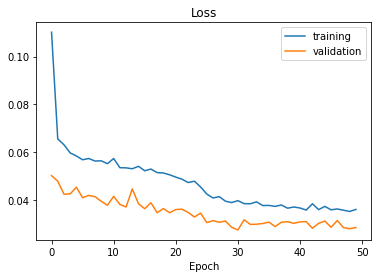

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

We will save the model.

In [32]:
model.save('model1.h5')